<a href="https://colab.research.google.com/github/zaidishz/GNN_XAI_Captum/blob/main/GNN_Explanation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explaining GNN Model Predictions using Captum

Mutagenicity dataset from [TUDatasets](https://chrsmrrs.github.io/datasets/). This dataset consists of 4337 molecule graphs where the task is to predict the molecule mutagenicity.

In [1]:
# Install required packages.
import os
from torch import __version__, tensor, int64
os.environ['TORCH'] = __version__
print(__version__)

%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io
import numpy as  np
import itertools
from sklearn.preprocessing import StandardScaler
import pandas as pd
from scipy.signal import hilbert, butter, filtfilt
from scipy.fftpack import fft,fftfreq,rfft,irfft,ifft
import scipy.stats as stats

2.0.1+cpu


## Loading the dataset

load the dataset (10% of the data as the test split)

In [2]:
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, Dataset
import os

proxy = 'http://webproxy:8080'

os.environ['http_proxy'] = proxy
os.environ['HTTP_PROXY'] = proxy
os.environ['https_proxy'] = proxy
os.environ['HTTPS_PROXY'] = proxy

In [3]:
achse_mat = scipy.io.loadmat('C:\\Users\\vedurm01\\PycharmProjects\\ZeMA_ML\\ZeMA_Matlab\\Achse11_Szenario.mat')

trainData = achse_mat['trainData']
train_data_reshaped = []
for counter, val in enumerate(trainData):
    train_data_reshaped += [val[0]]
train_data_reshaped = np.array(train_data_reshaped)
train_data_reshaped = np.swapaxes(train_data_reshaped, 0, 1)

train_target_reshaped = achse_mat['trainTarget'].reshape(-1)

sensor_names = ['Mic', 'APB', 'ABB', 'APR', 'AxF', 'Pre', 'Vel', 'ACu', 'MC1', 'MC2', 'MC3']

C:\Users\vedurm01\PycharmProjects\GNN_XAI_Captum\venv\lib\site-packages\scipy\io\matlab\_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [4]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

In [5]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

## Convert time-series data to torch geometric graph data. 1. Fully connected graph with 55 edges. Each edge has the correlation between the sensors as an attribute. 

## 2. Reduce number of edges by distarding those with a "below average" correlation 

In [6]:
dataset = []
combs = list(itertools.combinations(range(11), 2))
edge_index_perm = tensor(np.array(combs).T, dtype=int64)
triu_ind = np.triu_indices(11, k = 1)
N = 2000
Tsig = 1 / 2000.0
seconds = 5
fps = 50
lowcut  = 10
highcut = 500
fs = 2000.
order = 4

for k, sample in enumerate(train_data_reshaped):
    corr_mat = np.corrcoef(sample)
    corr_vec = np.reshape(corr_mat[triu_ind], (55,-1))
    corr_edge_inds = np.argwhere(np.abs(corr_vec) > np.abs(corr_vec).mean())
    edge_inds = edge_index_perm[:, corr_edge_inds[:,0]]
#     edge_inds = edge_index_perm
#     offset = []
#     for node_inds in edge_inds.T:
#         d1 = pd.Series(sample[node_inds[0]])
#         d2 = pd.Series(sample[node_inds[1]])
# #         rs = [crosscorr(d1, d2, lag) for lag in range(-int(500),int(501), 50)]
# #         offset.append(np.floor(len(rs)/2)-np.argmax(rs))
#         y1 = butter_bandpass_filter(d1,lowcut=lowcut,highcut=highcut,fs=fs,order=order)
#         y2 = butter_bandpass_filter(d2,lowcut=lowcut,highcut=highcut,fs=fs,order=order)

#         al1 = np.angle(hilbert(y1),deg=False)
#         al2 = np.angle(hilbert(y2),deg=False)
#         phase_synchrony = 1-np.sin(np.abs(al1-al2)/2)
#         offset.append(phase_synchrony)

#     edge_attr = np.stack((corr_vec[corr_edge_inds[:,0]].flatten(), np.array(offset)), axis=-1)
    edge_attr = corr_vec[corr_edge_inds[:,0]]
#     edge_attr = corr_vec
#     edge_attr = np.concatenate((corr_vec[corr_edge_inds[:,0]], np.array(offset)),axis=1)
    scaler = StandardScaler()
    array = scaler.fit_transform(sample.T).T
    array_fft = np.abs(fft(array)[:N//2])
    dataset += [Data(edge_index=edge_inds, x=tensor(array_fft), edge_attr= tensor(edge_attr), y=tensor([train_target_reshaped[k]]))]

In [7]:
test_dataset = dataset[:len(dataset) // 10]
train_dataset = dataset[len(dataset) // 10:]

test_loader = DataLoader(test_dataset, batch_size=128)
train_loader = DataLoader(train_dataset, batch_size=128)

## Visualizing the data


In [8]:
import networkx as nx
import numpy as np

from torch_geometric.utils import to_networkx

color_list = ['red', 'yellow']
rng = np.random.default_rng()

def draw_molecule(g, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    node_labels = {}
    d = dict(g.degree)
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
    widths = [7*np.abs(g[u][v]['edge_attr'])**.5 for u, v in g.edges()]
    nx.draw(g, pos=pos, labels=node_labels, width=.5,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color=rng.choice([t for t in color_list], size=g.number_of_nodes()), node_size=[v * 600 for v in d.values()]
)
    
    nx.draw_networkx_edges(g, pos, width=widths, alpha=0.5, edge_color='tab:red')
    
    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}    
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red', node_size=[v * 100 for v in d.values()])
    
#     pos_higher = {}
#     for k, v in pos.items():
#         if(v[1]>0):
#             pos_higher[k] = (v[0]+.035, v[1]+np.sqrt(d[k])*0.06)
#         else:
#             pos_higher[k] = (v[0]-.03, v[1]-np.sqrt(d[k])*0.06)

#     nx.draw_networkx_labels(g, pos=pos_higher,labels=node_labels)
    
    plt.show()


def to_molecule(data):
    g = to_networkx(data, node_attrs=['x'], edge_attrs=['edge_attr'])
    for u, data in g.nodes(data=True):
        data['name'] = sensor_names[u]
    return g

In [9]:
import random

data = random.choice([t for t in train_dataset])
print(data)
g = to_molecule(data)

Data(x=[11, 2000], edge_index=[2, 13], edge_attr=[13, 1], y=[1])


## Sample visualization

We sample a single molecule from train_dataset and visualize it

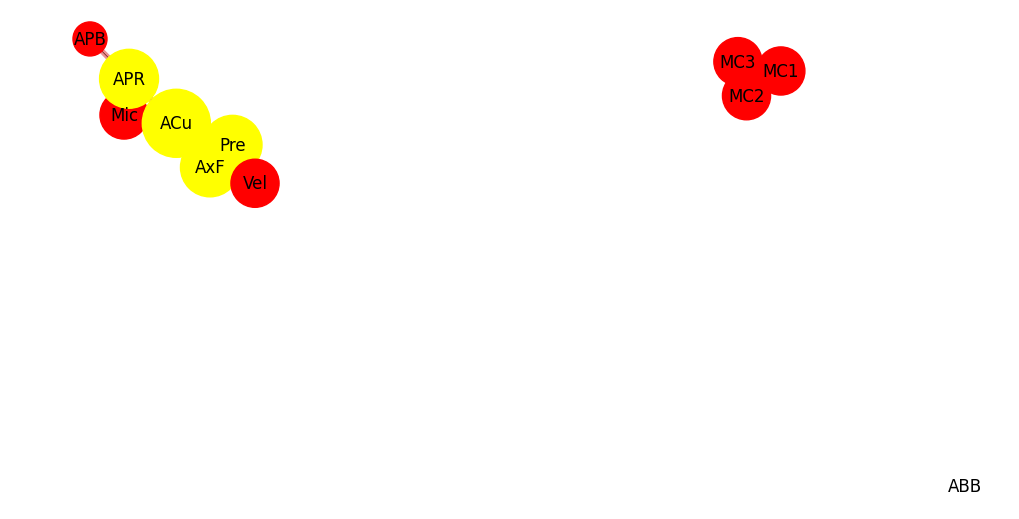

In [10]:
import random

data = random.choice([t for t in train_dataset])
mol = to_molecule(data)
plt.figure(figsize=(10, 5))
draw_molecule(mol, draw_edge_labels=False)

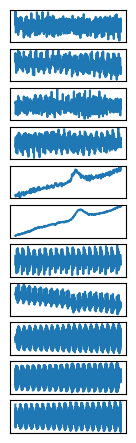

In [11]:
f, ax = plt.subplots(11,1, figsize=(1.5,5.5), sharex=True)
for k in range(11):
    ax[k].set_xticks([])
    ax[k].set_yticks([])
    ax[k].plot(train_data_reshaped[1500,k,50:-50:4])

In [ ]:
data = train_dataset[1500]
mol = to_molecule(data)
plt.figure(figsize=(10, 5))
draw_molecule(mol, draw_edge_labels=True)

In [ ]:
len(train_dataset)

In [ ]:
N = len(al1)

# Plot results
f,ax = plt.subplots(3,1,figsize=(14,7),sharex=True)
ax[0].plot(y1,color='r',label='y1')
ax[0].plot(y2,color='b',label='y2')
ax[0].legend(bbox_to_anchor=(0., 1.02, 1., .102),ncol=2)
ax[0].set(xlim=[0,N], title='Filtered Timeseries Data')
ax[1].plot(al1,color='r')
ax[1].plot(al2,color='b')
ax[1].set(ylabel='Angle',title='Angle at each Timepoint',xlim=[0,N])
phase_synchrony = 1-np.sin(np.abs(al1-al2)/2)
ax[2].plot(phase_synchrony)
ax[2].set(ylim=[0,1.1],xlim=[0,N],title='Instantaneous Phase Synchrony',xlabel='Time',ylabel='Phase Synchrony')
plt.tight_layout()
plt.show()

In [ ]:
from torch.nn import Linear, Module
import torch.nn.functional as F

from torch_geometric.nn import GraphConv, global_add_pool

class Net(Module):
    def __init__(self, dim):
        super(Net, self).__init__()

        num_features = 2000
        self.dim = dim

        self.conv1 = GraphConv(-1, dim)
        self.conv2 = GraphConv(dim, dim)
        self.conv3 = GraphConv(dim, dim)
        self.conv4 = GraphConv(dim, dim)
        self.conv5 = GraphConv(dim, dim)

        self.lin1 = Linear(dim, dim)
        self.lin2 = Linear(dim, 1)

    def forward(self, x, edge_index, batch, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = self.conv3(x, edge_index, edge_weight).relu()
        x = self.conv4(x, edge_index, edge_weight).relu()
        x = self.conv5(x, edge_index, edge_weight).relu()
        x = global_add_pool(x, batch)
        x = self.lin1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.relu(x)

In [ ]:
def train(epoch):
    model.train()

    if epoch == 51:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        loss = F.l1_loss(output, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_dataset)


def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

In [ ]:
from torch import device, optim, cuda
device = device('cuda' if cuda.is_available() else 'cpu')
model = Net(dim=32).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 101):
    loss = train(epoch)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

In [ ]:
for batch in train_loader:
    print(batch.num_graphs)

In [ ]:
from torch.utils.data import TensorDataset

In [ ]:
plt.hist(train_target_reshaped, bins=50)

<Axes: xlabel='0'>

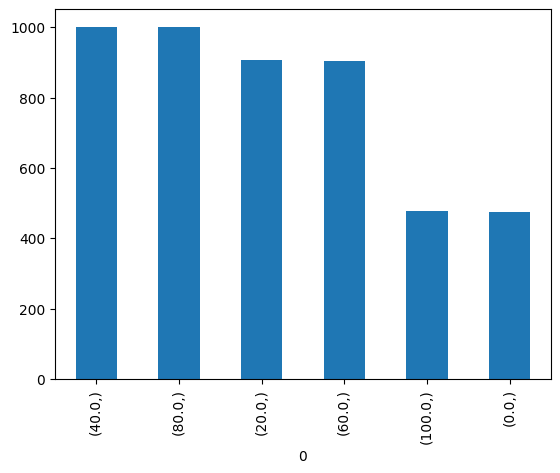

In [23]:
pd.DataFrame(20*np.round(train_target_reshaped/20)).value_counts().plot(kind='bar')

In [29]:
dataset[10].is_undirected()

False